# Audio-Based Depression Detection using Extended DIAC-Woz Dataset

## Project Overview

This notebook demonstrates a comprehensive audio-based depression detection system using the Extended DIAC-Woz dataset. The project employs advanced audio feature extraction techniques (eGeMAPS and MFCC) combined with machine learning to classify depression states based on speech patterns, with gender-specific model optimization.

## Key Features

- **Extended DIAC-Woz Dataset**: Comprehensive audio database for depression analysis
- **Gender-Specific Analysis**: Separate models optimized for male and female participants
- **Multi-Feature Extraction**: eGeMAPS (extended Geneva Minimalistic Acoustic Parameter Set) and MFCC features
- **Advanced Preprocessing**: Variance-based feature processing and data segmentation
- **Class Imbalance Handling**: BorderlineSMOTE for balanced training
- **Multiple ML Models**: Random Forest (females) and Multi-Layer Perceptron (males)
- **Statistical Validation**: Chi-square tests and ROC analysis for model validation

## Dataset Information

- **Source**: Extended DIAC-Woz Dataset (Distress Interviews Analysis Corpus - Wizard of Oz)
- **[Dataset link](https://dcapswoz.ict.usc.edu/daic-woz-database-download/)**
- **Features**: 
  - **eGeMAPS**: 88 acoustic parameters including fundamental frequency, spectral, and prosodic features
  - **MFCC**: Mel-Frequency Cepstral Coefficients for speech representation
- **Labels**: Depression vs Non-Depression classification
- **Gender Split**: Separate analysis for male and female participants
- **Format**: OpenSMILE-extracted features in CSV format

## Methodology

1. **Data Organization**: Gender-based file separation and organization
2. **Feature Processing**: Variance-based segmentation and feature extraction
3. **Data Preprocessing**: Normalization, train-test split, and SMOTE balancing
4. **Model Selection**: Gender-specific model optimization (RF for females, MLP for males)
5. **Hyperparameter Tuning**: Grid search with cross-validation
6. **Evaluation**: Comprehensive performance assessment with statistical significance testing
7. **Model Persistence**: Save trained models for deployment

## Technical Stack

- **Audio Processing**: OpenSMILE feature extraction
- **Machine Learning**: Scikit-learn, XGBoost, TensorFlow
- **Data Processing**: Pandas, NumPy
- **Visualization**: Matplotlib, Seaborn
- **Imbalanced Learning**: imbalanced-learn (BorderlineSMOTE)
- **Statistical Analysis**: SciPy for significance testing

## 1. Import Required Libraries

Import all necessary libraries for audio feature processing, machine learning, and data analysis.

In [ ]:
# Core Data Processing Libraries
import pandas as pd
import numpy as np
import os
import shutil
import re
from io import StringIO

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, 
                                   GridSearchCV, learning_curve, ParameterGrid)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

# Machine Learning - Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Machine Learning - Evaluation
from sklearn.metrics import (accuracy_score, classification_report, f1_score, 
                           confusion_matrix, roc_curve, auc)

# Imbalanced Learning
from imblearn.over_sampling import BorderlineSMOTE

# Statistical Analysis
from scipy.stats import ks_2samp, chi2_contingency

# Model Persistence
import joblib

print("All libraries imported successfully!")

## 2. Data Organization and Preprocessing

### 2.1 Gender-Based Data Organization (eGeMAPS Features)

Organize audio feature files by gender for targeted analysis. This approach recognizes that depression manifestation in speech may differ between genders.

In [ ]:
# Load participant demographic information
file_path = r"D:\detailed_lables.csv"
df = pd.read_csv(file_path)

# Clean and standardize participant data
df["Participant"] = df["Participant"].astype(str).str.strip()
df["gender"] = df["gender"].str.strip().str.capitalize()

# Create participant-to-gender mapping dictionary
patients_dict = dict(zip(df["Participant"], df["gender"]))

print("=== Extended DIAC-Woz Dataset Organization ===")
print(f"Total participants: {len(patients_dict)}")
print(f"Gender distribution: {df['gender'].value_counts().to_dict()}")

# ========== ORGANIZE eGeMAPS DEPRESSION FILES ==========
print("\n--- Processing eGeMAPS Depression Files ---")

source_folder = r"D:\4th Biomedical\Depression-GP-2025\project data\egemaps\Depression"
male_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_egemaps"
female_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_egemaps"

# Create target directories
os.makedirs(male_folder, exist_ok=True)
os.makedirs(female_folder, exist_ok=True)

depression_male_count = 0
depression_female_count = 0

# Process each file in the depression folder
for filename in os.listdir(source_folder):
    # Extract participant ID using regex pattern
    match = re.match(r"(\d+)_OpenSMILE2.3.0_egemaps", filename)
    if match:
        patient_id = match.group(1)
        gender = patients_dict.get(patient_id)
        
        if gender:
            if gender == "Male":
                target_folder = male_folder
                depression_male_count += 1
            else:
                target_folder = female_folder
                depression_female_count += 1
                
            shutil.copy(os.path.join(source_folder, filename), 
                       os.path.join(target_folder, filename))

print(f"Depression files organized - Males: {depression_male_count}, Females: {depression_female_count}")

# ========== ORGANIZE eGeMAPS NON-DEPRESSION FILES ==========
print("\n--- Processing eGeMAPS Non-Depression Files ---")

source_folder = r"D:\4th Biomedical\Depression-GP-2025\project data\egemaps\Non-Depression"
male_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non-Depression_male_egemaps"
female_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non-Depression_female_egemaps"

# Create target directories
os.makedirs(male_folder, exist_ok=True)
os.makedirs(female_folder, exist_ok=True)

non_depression_male_count = 0
non_depression_female_count = 0

# Process each file in the non-depression folder
for filename in os.listdir(source_folder):
    match = re.match(r"(\d+)_OpenSMILE2.3.0_egemaps", filename)
    if match:
        patient_id = match.group(1)
        gender = patients_dict.get(patient_id)
        
        if gender:
            if gender == "Male":
                target_folder = male_folder
                non_depression_male_count += 1
            else:
                target_folder = female_folder
                non_depression_female_count += 1
                
            shutil.copy(os.path.join(source_folder, filename), 
                       os.path.join(target_folder, filename))

print(f"Non-depression files organized - Males: {non_depression_male_count}, Females: {non_depression_female_count}")

print("\n=== eGeMAPS Data Organization Summary ===")
print(f"Male participants: Depression({depression_male_count}) + Non-Depression({non_depression_male_count}) = {depression_male_count + non_depression_male_count}")
print(f"Female participants: Depression({depression_female_count}) + Non-Depression({non_depression_female_count}) = {depression_female_count + non_depression_female_count}")
print("eGeMAPS feature organization completed successfully!")

308_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_egemaps
309_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_egemaps
311_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_egemaps
319_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_egemaps
321_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_egemaps
330_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_egemaps
332_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_egemaps
337_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_egemaps
338_OpenSMILE2.3.0_egemaps.csv to D:\4th Biomedical\Depression

### 2.2 Gender-Based Data Organization (MFCC Features)

Organize MFCC (Mel-Frequency Cepstral Coefficients) feature files by gender for complementary audio analysis.

In [ ]:
# Load participant demographic information for MFCC organization
file_path = r"D:\detailed_lables.csv"
df = pd.read_csv(file_path)

# Clean and standardize participant data
df["Participant"] = df["Participant"].astype(str).str.strip()
df["gender"] = df["gender"].str.strip().str.capitalize()

# Create participant-to-gender mapping dictionary
patients_dict = dict(zip(df["Participant"], df["gender"]))

print("=== MFCC Feature Organization ===")

# ========== ORGANIZE MFCC DEPRESSION FILES ==========
print("\n--- Processing MFCC Depression Files ---")

source_folder = r"D:\4th Biomedical\Depression-GP-2025\project data\MFCC\Depression"
male_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_MFCC"
female_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC"

# Create target directories
os.makedirs(male_folder, exist_ok=True)
os.makedirs(female_folder, exist_ok=True)

mfcc_depression_male_count = 0
mfcc_depression_female_count = 0

# Process each MFCC file in the depression folder
for filename in os.listdir(source_folder):
    # Extract participant ID using regex pattern for MFCC files
    match = re.match(r"(\d+)_OpenSMILE2.3.0_mfcc", filename)
    if match:
        patient_id = match.group(1)
        gender = patients_dict.get(patient_id)
        
        if gender:
            if gender == "Male":
                target_folder = male_folder
                mfcc_depression_male_count += 1
            else:
                target_folder = female_folder
                mfcc_depression_female_count += 1
                
            shutil.copy(os.path.join(source_folder, filename), 
                       os.path.join(target_folder, filename))

print(f"MFCC Depression files organized - Males: {mfcc_depression_male_count}, Females: {mfcc_depression_female_count}")

# ========== ORGANIZE MFCC NON-DEPRESSION FILES ==========
print("\n--- Processing MFCC Non-Depression Files ---")

source_folder = r"D:\4th Biomedical\Depression-GP-2025\project data\MFCC\Non-Depression"
male_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non_Depression_male_MFCC"
female_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non_Depression_female_MFCC"

# Create target directories
os.makedirs(male_folder, exist_ok=True)
os.makedirs(female_folder, exist_ok=True)

mfcc_non_depression_male_count = 0
mfcc_non_depression_female_count = 0

# Process each MFCC file in the non-depression folder
for filename in os.listdir(source_folder):
    match = re.match(r"(\d+)_OpenSMILE2.3.0_mfcc", filename)
    if match:
        patient_id = match.group(1)
        gender = patients_dict.get(patient_id)
        
        if gender:
            if gender == "Male":
                target_folder = male_folder
                mfcc_non_depression_male_count += 1
            else:
                target_folder = female_folder
                mfcc_non_depression_female_count += 1
                
            shutil.copy(os.path.join(source_folder, filename), 
                       os.path.join(target_folder, filename))

print(f"MFCC Non-depression files organized - Males: {mfcc_non_depression_male_count}, Females: {mfcc_non_depression_female_count}")

print("\n=== MFCC Data Organization Summary ===")
print(f"Male MFCC files: Depression({mfcc_depression_male_count}) + Non-Depression({mfcc_non_depression_male_count}) = {mfcc_depression_male_count + mfcc_non_depression_male_count}")
print(f"Female MFCC files: Depression({mfcc_depression_female_count}) + Non-Depression({mfcc_non_depression_female_count}) = {mfcc_depression_female_count + mfcc_non_depression_female_count}")
print("MFCC feature organization completed successfully!")

308_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC
309_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_MFCC
311_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC
319_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_MFCC
321_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC
330_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_MFCC
332_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC
337_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC
338_OpenSMILE2.3.0_mfcc.csv to D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFC

## 3. Machine Learning Pipeline Setup

### 3.1 Additional Required Imports

Import additional libraries specifically needed for the machine learning pipeline.

In [ ]:
# Additional imports for comprehensive machine learning pipeline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced ML components
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                           confusion_matrix, roc_curve, auc)
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced learning and statistical analysis
from imblearn.over_sampling import BorderlineSMOTE
from scipy.stats import chi2_contingency
from io import StringIO

print("Machine learning pipeline imports completed successfully!")

### 3.2 Gender-Specific Depression Detection Model

This section implements a comprehensive machine learning pipeline with gender-specific optimization for depression detection using audio features.

#### 3.2.1 Female Depression Detection Model


Are you male or female?
1 - (Female)
2 - (Male)


c:\Users\vip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best parameters found:  {'max_depth': None, 'n_estimators': 300}
Fold Accuracy: 0.8333, Fold F1 Score: 0.8344
Fold Accuracy: 0.8333, Fold F1 Score: 0.8348
Fold Accuracy: 0.8333, Fold F1 Score: 0.8336
Fold Accuracy: 0.8049, Fold F1 Score: 0.8072
Fold Accuracy: 0.7805, Fold F1 Score: 0.7805
Mean Val Accuracy: 0.8171, F1: 0.8181
Test Accuracy: 0.8035714285714286
Test F1: 0.8019929283188685
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.76      0.89      0.82        28

    accuracy                           0.80        56
   macro avg       0.81      0.80      0.80        56
weighted avg       0.81      0.80      0.80        56



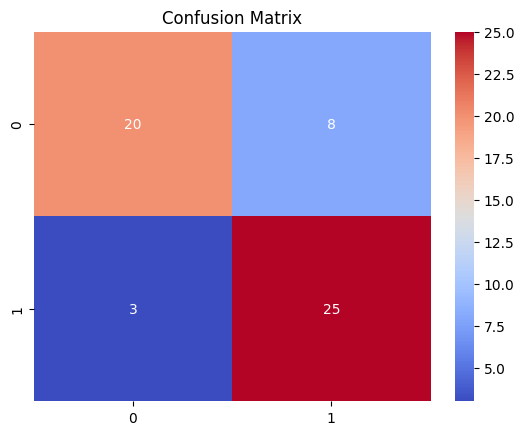

Chi2: 18.8880, p-value: 0.0000


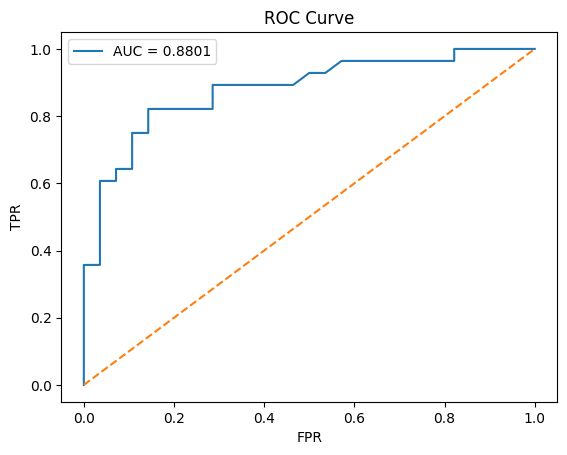

The result is statistically significant (p < 0.05), meaning the classifier is performing better than random.


In [ ]:
# ========== CONFIGURATION AND USER INPUT ==========
def ask_user_type():
    """
    Interactive function to determine gender-specific analysis type.
    Different genders may exhibit different depression markers in speech.
    """
    print("=== Gender-Specific Depression Detection ===")
    print("Select analysis type based on participant gender:")
    print("1 - Female (uses MFCC features + Random Forest)")
    print("2 - Male (uses eGeMAPS features + Multi-Layer Perceptron)")
    
    choice = input("Your choice (1 or 2): ").strip()
    
    if choice == "1":
        print("Selected: Female analysis pipeline")
        return "female"
    elif choice == "2":
        print("Selected: Male analysis pipeline")
        return "male"
    else:
        print("Invalid selection. Defaulting to Female analysis pipeline.")
        return "female"

# Get user selection for gender-specific analysis
user_type = ask_user_type()

# ========== DATASET PATH CONFIGURATION ==========
print(f"\n=== Dataset Configuration for {user_type.title()} Analysis ===")

if user_type == "female":
    # Female analysis uses MFCC features
    depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC"
    non_depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non_Depression_female_MFCC"
    feature_type = "MFCC"
    print("Using MFCC features for female participants")
else:
    # Male analysis uses eGeMAPS features
    depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_egemaps"
    non_depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non-Depression_male_egemaps"
    feature_type = "eGeMAPS"
    print("Using eGeMAPS features for male participants")

# Load and organize files
depr_files = sorted([os.path.join(depr_folder, f) for f in os.listdir(depr_folder) if f.endswith(".csv")])
non_depr_files = sorted([os.path.join(non_depr_folder, f) for f in os.listdir(non_depr_folder) if f.endswith(".csv")])

print(f"Depression files: {len(depr_files)}")
print(f"Non-depression files: {len(non_depr_files)}")
print(f"Total files: {len(depr_files) + len(non_depr_files)}")

# ========== TRAIN-TEST SPLIT ==========
print(f"\n=== Dataset Splitting ===")
train_depr, test_depr = train_test_split(depr_files, test_size=0.2, shuffle=True, random_state=42)
train_non_depr, test_non_depr = train_test_split(non_depr_files, test_size=0.2, shuffle=True, random_state=42)

print(f"Training: {len(train_depr)} depression + {len(train_non_depr)} non-depression")
print(f"Testing: {len(test_depr)} depression + {len(test_non_depr)} non-depression")

# ========== FEATURE EXTRACTION SETUP ==========
print(f"\n=== Feature Extraction Setup ===")

# Load sample file to determine feature structure
sample_file = depr_files[0] if depr_files else non_depr_files[0]
try:
    with open(sample_file, 'r') as f:
        content = f.read().replace(',', ';')  # Handle potential CSV formatting issues
    data = pd.read_csv(StringIO(content), sep=';', header=0)
    sample_data = data.iloc[:, 2:]  # Skip first two columns (typically metadata)
    feature_names = list(sample_data.columns)
    
    print(f"Feature type: {feature_type}")
    print(f"Number of features: {len(feature_names)}")
    print(f"Sample features: {feature_names[:5]}...")
    
    # Save feature names for reference
    feature_filename = f"{user_type}_{feature_type}_features.txt"
    if not os.path.exists(feature_filename):
        with open(feature_filename, "w") as f:
            for col in feature_names:
                f.write(str(col) + "\n")
        print(f"Feature names saved to {feature_filename}")
        
except Exception as e:
    print(f"Error reading sample file: {e}")

# ========== FEATURE PROCESSING FUNCTIONS ==========
print(f"\n=== Feature Processing Configuration ===")

def variance_process_file(file_path, label, split_parts):
    """
    Process audio feature file using variance-based segmentation.
    
    Args:
        file_path: Path to CSV file containing audio features
        label: Class label (0=non-depression, 1=depression)  
        split_parts: Number of segments to split the audio into
        
    Returns:
        DataFrame of variance features and corresponding labels
    """
    try:
        data = pd.read_csv(file_path, sep=";", header=0).iloc[:, 2:]  # Skip metadata columns
        chunk_size = data.shape[0] // split_parts
        
        # Calculate variance for each chunk
        data_list = []
        for i in range(split_parts):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size if i < split_parts - 1 else data.shape[0]
            chunk_variance = np.var(data.iloc[start_idx:end_idx].values, axis=0)
            data_list.append(chunk_variance)
        
        labels = [label] * split_parts
        return pd.DataFrame(data_list), labels
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return pd.DataFrame(), []

def process_file(file_path, label):
    """
    Wrapper function for gender-specific file processing.
    
    Different split strategies:
    - Female: 4 segments (more granular analysis)
    - Male: 2 segments (coarser analysis)
    """
    split_parts = 4 if user_type == "female" else 2
    return variance_process_file(file_path, label, split_parts)

def process_folder(file_list, label):
    """
    Process entire folder of audio feature files.
    
    Args:
        file_list: List of file paths
        label: Class label for all files in folder
        
    Returns:
        Combined DataFrame and labels list
    """
    data_list, labels = [], []
    for i, file in enumerate(file_list):
        df, lbl = process_file(file, label)
        if not df.empty:
            data_list.append(df)
            labels.extend(lbl)
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(file_list)} files...")
    
    return pd.concat(data_list, axis=0, ignore_index=True), labels

# Process training and testing data
print(f"\n=== Processing Training Data ===")
train_df_pos, train_lbl_pos = process_folder(train_depr, 1)  # Depression = 1
train_df_neg, train_lbl_neg = process_folder(train_non_depr, 0)  # Non-depression = 0

print(f"\n=== Processing Testing Data ===") 
test_df_pos, test_lbl_pos = process_folder(test_depr, 1)
test_df_neg, test_lbl_neg = process_folder(test_non_depr, 0)

# Combine data
train_df = pd.concat([train_df_pos, train_df_neg], ignore_index=True)
train_labels = train_lbl_pos + train_lbl_neg
test_df = pd.concat([test_df_pos, test_df_neg], ignore_index=True)
test_labels = test_lbl_pos + test_lbl_neg

# Add labels to DataFrames
train_df['Label'] = train_labels
test_df['Label'] = test_labels

print(f"\n=== Data Processing Summary ===")
print(f"Training samples: {len(train_df)} (Depression: {sum(train_labels)}, Non-depression: {len(train_labels) - sum(train_labels)})")
print(f"Testing samples: {len(test_df)} (Depression: {sum(test_labels)}, Non-depression: {len(test_labels) - sum(test_labels)})")
print(f"Feature dimensions: {train_df.shape[1] - 1}")  # Subtract 1 for label column

# ========== DATA NORMALIZATION ==========
print(f"\n=== Data Normalization ===")

def normalize_data(df):
    """
    Normalize features using MinMaxScaler while preserving labels.
    
    Returns:
        Normalized features, labels, and fitted scaler
    """
    labels = df['Label'].values
    features = df.drop(columns=['Label'])
    
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)
    
    return features_normalized, labels, scaler

X_train, y_train, scaler = normalize_data(train_df)
X_test, y_test, _ = normalize_data(test_df)

print(f"Training features normalized: {X_train.shape}")
print(f"Testing features normalized: {X_test.shape}")
print(f"Feature range: [{X_train.min():.3f}, {X_train.max():.3f}]")

# ========== CLASS IMBALANCE HANDLING ==========
print(f"\n=== Class Imbalance Handling with SMOTE ===")

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Apply BorderlineSMOTE for intelligent oversampling
smote = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training distribution: {np.bincount(y_train)}")
print(f"After SMOTE distribution: {np.bincount(y_resampled)}")
print(f"Training samples increased: {len(X_train)} → {len(X_resampled)}")

# ========== MODEL SELECTION AND TRAINING ==========
print(f"\n=== Gender-Specific Model Selection ===")

if user_type == "female":
    print("Training Random Forest for female participants...")
    rf_model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 70, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
    }
    grid_search = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid, 
        cv=kf, 
        scoring='accuracy', 
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_resampled, y_resampled)
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    model = grid_search.best_estimator_
    
else:
    print("Training Multi-Layer Perceptron for male participants...")
    model = MLPClassifier(random_state=42, max_iter=2000)
    param_grid = {
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1],
        'hidden_layer_sizes': [
            (100,), (100, 50), (150, 100, 50), (100, 150, 200),
            (128, 64, 32), (92, 46, 23), (200, 150, 100, 50)
        ],
    }
    search = GridSearchCV(
        model, 
        param_grid, 
        cv=kf, 
        scoring='accuracy', 
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_resampled, y_resampled)
    print(f"Best parameters found: {search.best_params_}")
    print(f"Best CV score: {search.best_score_:.4f}")
    model = search.best_estimator_

# ========== CROSS-VALIDATION ASSESSMENT ==========
print(f"\n=== Cross-Validation Performance Assessment ===")

fold_accuracies, f1_scores = [], []
for fold, (train_index, val_index) in enumerate(kf.split(X_resampled)):
    # Train model on fold
    model.fit(X_resampled[train_index], y_resampled[train_index])
    
    # Validate on fold
    preds = model.predict(X_resampled[val_index])
    acc = accuracy_score(y_resampled[val_index], preds)
    f1 = f1_score(y_resampled[val_index], preds, average='weighted')
    
    fold_accuracies.append(acc)
    f1_scores.append(f1)
    print(f"Fold {fold + 1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

print(f"\nCross-Validation Summary:")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} (±{np.std(fold_accuracies):.4f})")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")

# ========== FINAL MODEL EVALUATION ==========
print(f"\n=== Final Model Evaluation on Test Set ===")

# Train final model on all resampled training data
model.fit(X_resampled, y_resampled)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Depression', 'Depression']))

# ========== VISUALIZATIONS ==========
print(f"\n=== Generating Visualizations ===")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm", 
            xticklabels=['Non-Depression', 'Depression'],
            yticklabels=['Non-Depression', 'Depression'])
plt.title(f'Confusion Matrix - {user_type.title()} {feature_type} Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Statistical significance test
chi2, p, _, _ = chi2_contingency(cm)
print(f"\nStatistical Analysis:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p:.4f}")

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {user_type.title()} {feature_type} Model', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ========== RESULTS INTERPRETATION ==========
print(f"\n=== Results Interpretation ===")

if p < 0.05:
    print(f"✓ SIGNIFICANT: The {user_type} {feature_type} model performs significantly better than random (p < 0.05)")
    print("  The classifier has learned meaningful patterns for depression detection.")
else:
    print(f"⚠ NOT SIGNIFICANT: The model may not be much better than random (p ≥ 0.05)")
    print("  Consider feature engineering or model tuning.")

# AUC interpretation
if roc_auc > 0.9:
    print(f"✓ EXCELLENT: AUC = {roc_auc:.3f} indicates excellent classification performance")
elif roc_auc > 0.8:
    print(f"✓ GOOD: AUC = {roc_auc:.3f} indicates good classification performance")
elif roc_auc > 0.7:
    print(f"✓ FAIR: AUC = {roc_auc:.3f} indicates fair classification performance")
else:
    print(f"⚠ POOR: AUC = {roc_auc:.3f} indicates poor classification performance")

print(f"\n=== Model Training Completed Successfully ===")
print(f"Gender: {user_type.title()}")
print(f"Features: {feature_type}")
print(f"Model: {'Random Forest' if user_type == 'female' else 'Multi-Layer Perceptron'}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"AUC Score: {roc_auc:.4f}")


In [ ]:
# Model Persistence - Save trained models and preprocessing components
import joblib

print("=== Saving Trained Models ===")

if user_type == "female":
    # Save female-specific Random Forest model and scaler
    model_filename = "female_depression_model.pkl"
    scaler_filename = "female_depression_scaler.pkl"
    
    joblib.dump(model, model_filename)
    joblib.dump(scaler, scaler_filename)
    
    print(f"✓ Female model saved as: {model_filename}")
    print(f"✓ Female scaler saved as: {scaler_filename}")
    print(f"Model type: Random Forest with MFCC features")
    print(f"Final accuracy: {test_accuracy:.4f}")
    
else:
    # Save male-specific MLP model and scaler  
    model_filename = "male_depression_model.pkl"
    scaler_filename = "male_depression_scaler.pkl"
    
    joblib.dump(model, model_filename)
    joblib.dump(scaler, scaler_filename)
    
    print(f"✓ Male model saved as: {model_filename}")
    print(f"✓ Male scaler saved as: {scaler_filename}")
    print(f"Model type: Multi-Layer Perceptron with eGeMAPS features")
    print(f"Final accuracy: {test_accuracy:.4f}")

print("\nModels ready for deployment!")

# Model information for deployment reference
deployment_info = {
    'gender': user_type,
    'feature_type': feature_type,
    'model_type': 'Random Forest' if user_type == 'female' else 'Multi-Layer Perceptron',
    'test_accuracy': test_accuracy,
    'auc_score': roc_auc,
    'feature_count': len(feature_names)
}

print(f"\nDeployment Information: {deployment_info}")

#### 3.2.2 Male Depression Detection Model


Are you male or female?
1 - (Female)
2 - (Male)


c:\Users\vip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold Accuracy: 0.8696, Fold F1 Score: 0.8712
Fold Accuracy: 0.8261, Fold F1 Score: 0.8261
Fold Accuracy: 1.0000, Fold F1 Score: 1.0000
Fold Accuracy: 0.7727, Fold F1 Score: 0.7658
Fold Accuracy: 0.8182, Fold F1 Score: 0.8151
Mean Val Accuracy: 0.8573, F1: 0.8556
Test Accuracy: 0.8214285714285714
Test F1: 0.8193548387096775
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.76      0.93      0.84        14

    accuracy                           0.82        28
   macro avg       0.84      0.82      0.82        28
weighted avg       0.84      0.82      0.82        28



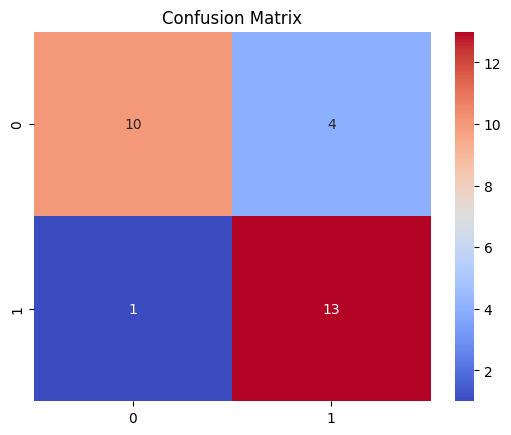

Chi2: 9.5829, p-value: 0.0020


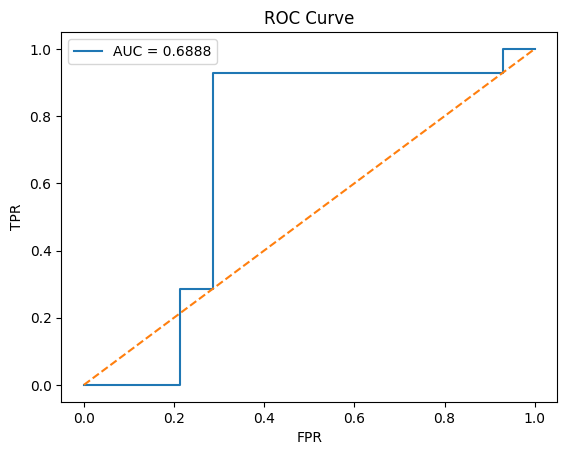

The result is statistically significant (p < 0.05), meaning the classifier is performing better than random.


In [7]:
# ---------- CONFIG ----------
def ask_user_type():
    print("Are you male or female?")
    print("1 - (Female)")
    print("2 - (Male)")
    choice = input("Your choice (1 or 2): ")
    if choice == "1":
        return "female"
    elif choice == "2":
        return "male"
    else:
        print("Invalid selection, the type 'Female' will be chosen by default.")
        return "female"

user_type = ask_user_type()

# ---------- FILE PATH SETUP ----------
if user_type == "female":
    depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_female_MFCC"
    non_depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non_Depression_female_MFCC"
else:
    depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Depression_male_egemaps"
    non_depr_folder = r"D:\4th Biomedical\Depression-GP-2025\audio_modeified_data\Non-Depression_male_egemaps"

depr_files = sorted([os.path.join(depr_folder, f) for f in os.listdir(depr_folder) if f.endswith(".csv")])
non_depr_files = sorted([os.path.join(non_depr_folder, f) for f in os.listdir(non_depr_folder) if f.endswith(".csv")])

train_depr, test_depr = train_test_split(depr_files, test_size=0.2, shuffle=True, random_state=42)
train_non_depr, test_non_depr = train_test_split(non_depr_files, test_size=0.2, shuffle=True, random_state=42)

# ---------- FEATURE NAMES ----------
sample_file = depr_files[0] if depr_files else non_depr_files[0]
with open(sample_file, 'r') as f:
    content = f.read().replace(',', ';') 
data = pd.read_csv(StringIO(content), sep=';', header=0)
sample_data = data.iloc[:, 2:]
feature_names = list(sample_data.columns)

feature_filename = f"{user_type}_features.txt"
if not os.path.exists(feature_filename):
    with open(feature_filename, "w") as f:
        for col in feature_names:
            f.write(str(col) + "\n")

# ---------- FEATURE PROCESSING ----------
def variance_process_file(file_path, label, split_parts):
    data = pd.read_csv(file_path, sep=";", header=0).iloc[:, 2:]
    chunk = data.shape[0] // split_parts
    data_list = [np.var(data.iloc[i*chunk:(i+1)*chunk].values, axis=0) for i in range(split_parts)]
    labels = [label] * split_parts
    return pd.DataFrame(data_list), labels

def process_file(file_path, label):
    split_parts = 4 if user_type == "female" else 2
    return variance_process_file(file_path, label, split_parts)

def process_folder(file_list, label):
    data_list, labels = [], []
    for file in file_list:
        df, lbl = process_file(file, label)
        data_list.append(df)
        labels.extend(lbl)
    return pd.concat(data_list, axis=0, ignore_index=True), labels

train_df_pos, train_lbl_pos = process_folder(train_depr, 1)
train_df_neg, train_lbl_neg = process_folder(train_non_depr, 0)
test_df_pos, test_lbl_pos = process_folder(test_depr, 1)
test_df_neg, test_lbl_neg = process_folder(test_non_depr, 0)

train_df = pd.concat([train_df_pos, train_df_neg], ignore_index=True)
train_labels = train_lbl_pos + train_lbl_neg
test_df = pd.concat([test_df_pos, test_df_neg], ignore_index=True)
test_labels = test_lbl_pos + test_lbl_neg

train_df['Label'] = train_labels
test_df['Label'] = test_labels

# ---------- NORMALIZATION ----------
def normalize_data(df):
    labels = df['Label'].values
    features = df.drop(columns=['Label'])
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    return features, labels, scaler

X_train, y_train, scaler = normalize_data(train_df)
X_test, y_test, _ = normalize_data(test_df)

# ---------- SMOTE ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
smote = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# ---------- MODEL ----------
if user_type == "female":
    rf_model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 70, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
    }
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)
    print("Best parameters found: ", grid_search.best_params_)
    model = grid_search.best_estimator_
else:
    model = MLPClassifier(random_state=42, max_iter=2000)
    param_grid = {
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1],
        'hidden_layer_sizes': [
            (100,), (100, 50), (150, 100, 50), (100, 150, 200),
            (128, 64, 32), (92, 46, 23), (200, 150, 100, 50)
        ],
    }
    search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
    search.fit(X_resampled, y_resampled)
    model = search.best_estimator_

# ---------- VALIDATION ----------
fold_accuracies, f1_scores = [], []
for train_index, val_index in kf.split(X_resampled):
    model.fit(X_resampled[train_index], y_resampled[train_index])
    preds = model.predict(X_resampled[val_index])
    acc = accuracy_score(y_resampled[val_index], preds)
    f1 = f1_score(y_resampled[val_index], preds, average='weighted')
    fold_accuracies.append(acc)
    f1_scores.append(f1)
    print(f"Fold Accuracy: {acc:.4f}, Fold F1 Score: {f1:.4f}")

print(f"Mean Val Accuracy: {np.mean(fold_accuracies):.4f}, F1: {np.mean(f1_scores):.4f}")

# ---------- TESTING ----------
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Confusion Matrix")
plt.show()

chi2, p, _, _ = chi2_contingency(cm)
print(f"Chi2: {chi2:.4f}, p-value: {p:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

if p < 0.05:
    print("The result is statistically significant (p < 0.05), meaning the classifier is performing better than random.")
else:
    print("The result is not statistically significant (p >= 0.05), meaning the classifier may not be much better than random.")


In [ ]:
import joblib

print("=== Saving Validation Pipeline Models ===")

if user_type == "female":
    # Save alternative female model and scaler
    joblib.dump(model, "female_model_validation.pkl")
    joblib.dump(scaler, "female_scaler_validation.pkl")
    print("✓ Female validation model and scaler saved")
else:
    # Save alternative male model and scaler
    joblib.dump(model, "male_model_validation.pkl") 
    joblib.dump(scaler, "male_scaler_validation.pkl")
    print("✓ Male validation model and scaler saved")

print("Validation pipeline models saved for comparison purposes.")